In [94]:
import torch, torch.nn as nn

In [377]:
class Linear_Layer:
    def __init__(self, features_in, features_out):
        self.weights = torch.normal(0,1/features_in,(features_out, features_in))
        self.bias = torch.zeros((features_out,1))
        self.prev_hidden_state = None

        self.w_grads = None
        self.b_grads = None

    def __call__(self, X):
        self.prev_hidden_state = X
        hidden_state = self.weights@X + self.bias
        return hidden_state

    def grad_calc(self, grads):
        self.w_grads = grads@(self.prev_hidden_state.T)
        self.b_grads = grads@torch.ones(self.prev_hidden_state.shape[1],1)

        self.h_grads = self.weights.T @ grads
        return self.h_grads

    def step(self, lr_rate):
        self.weights -= lr_rate*self.w_grads
        self.bias -= lr_rate*self.b_grads

In [217]:
class relu:
    def __init__(self):
        self.activations = None

    def __call__(self, X):
        self.activations = torch.maximum(torch.zeros(X.shape),X)
        return self.activations

    def grad_calc(self, grads):
        return grads * (self.activations>0).to(grads.dtype)

In [218]:
class sigmoid:
    def __init__(self):
        self.activations = None

    def __call__(self, X):
        self.activations = 1/(1+torch.exp(-1*X))
        return self.activations

    def grad_calc(self, grads):
        return grads * (self.activations*(1-self.activations))

In [326]:
class Sequential_Model:
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss_fn = loss_fn
        self.y_grads = None

    def forward_pass(self, X):
        for layer in self.layers:
            X = layer(X)

        return X

    def loss_calc(self, targets, preds):
        [loss, self.y_grads] = self.loss_fn(targets, preds)
        return loss

    def backward_pass(self):
        grads = self.y_grads
        
        for layer in self.layers[::-1]:
            grads = layer.grad_calc(grads)

    def step(self, lr_rate):
        for layer in self.layers[::-1]:
            if isinstance(layer, Linear_Layer):
                layer.step(lr_rate)

In [440]:
def log_loss(targets, preds):
    m = preds.shape[1]
    loss_arr = targets*(torch.log(preds+1e-8)) + (1-targets)*(torch.log(1-preds+1e-8))
    loss = -1*torch.sum(loss_arr)/m

    grads = (-1/m)*(targets/(preds+1e-8) - (1-targets)/(1-preds+1e-8))
    
    return [loss, grads]

In [467]:
def accuracy(targets, preds):
    y_preds = (preds>0.5).to(targets.dtype)
    acc = torch.sum(y_preds==targets)/targets.shape[0]
    return acc

In [463]:
d_in = 1
d_h = 4
d_o = 1

In [464]:
x_rand = torch.normal(0,1,(d_in,100))
y_rand = torch.sum(x_rand, dim=0)
y_rand = (y_rand>0).to(x_rand.dtype)

In [468]:
model = Sequential_Model([Linear_Layer(d_in,d_h),
                          relu(),
                          Linear_Layer(d_h,d_o),
                          sigmoid()], log_loss)

In [469]:
epochs = 1000
loss_history = []
acc_history = []

for i in range(epochs):
    preds = model.forward_pass(x_rand)
    #print(preds, y_rand)
    loss = model.loss_calc(y_rand, preds)
    model.backward_pass()
    model.step(1e-3)
    
    loss_history.append(loss)
    acc_history.append(accuracy(y_rand, preds))

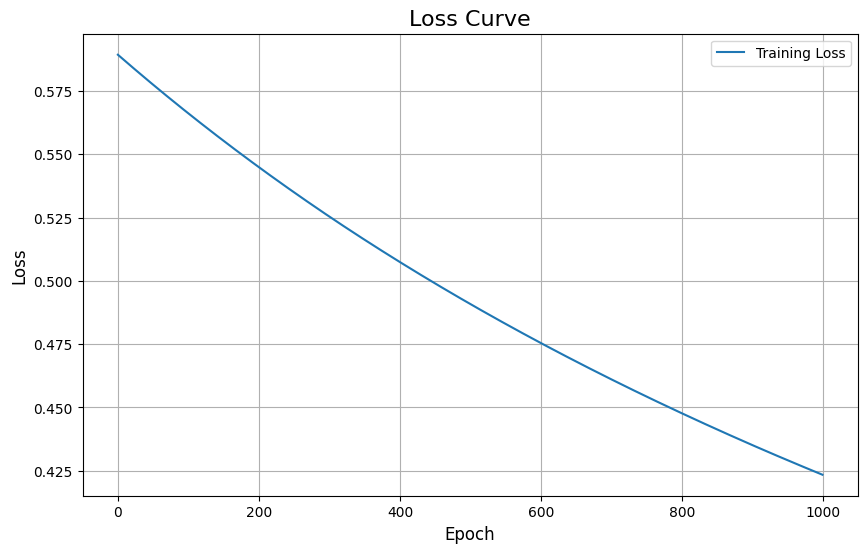

In [470]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), loss_history, label='Training Loss')
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

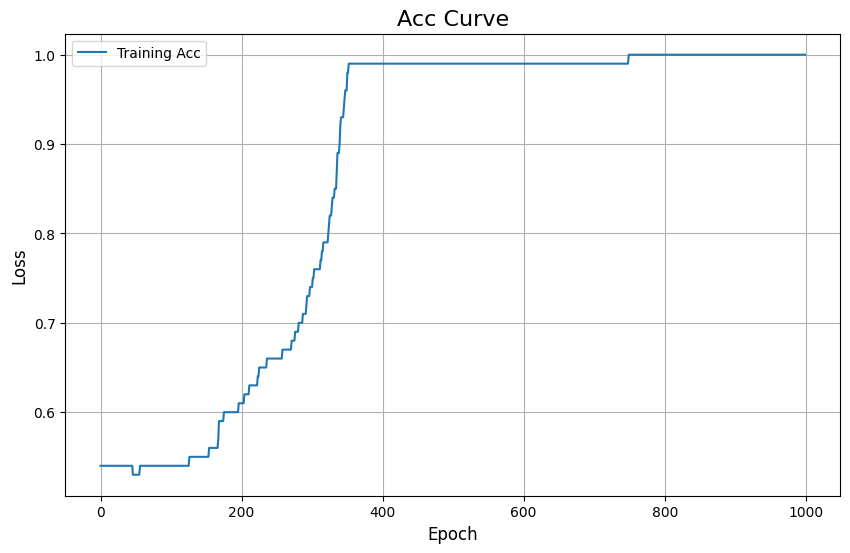

In [471]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), acc_history, label='Training Acc')
plt.title('Acc Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)